In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import preliz as pz
import pymc as pm

In [2]:
az.style.use('arviz-white')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

##### <center><img src="img/logo_inst.png" width="750">
<br>
<br>
<br>
<br>
<h1 align="center">Modelos Jerárquicos</h1>    


<br>
<br>
<br>
<br>
<br>

## Modelos Jerárquicos


* Una situación común en estadística se da cuando tenemos varias unidades o grupos similares que queremos analizar
    
* Las dos estrategias más comunes son
    * estudiar cada grupo por separado
    * unificar los grupos en uno solo

## Agrupamiento parcial

<br>

<center><img src="img/pooling.png" width="300"></center>

## Hiper-priors

* Podemos lograr agrupamiento parcial asumiendo que uno (o más) parámetros vienen de una (o más) distribuciones comunes, o hiper-priors

<center><img src="img/hierarchical_model.png" width="500"></center>


## El problema de las 3 monedas

<br>

* Tenemos 3 monedas fabricadas por la misma matriz.


* Para estimar el valor de $\theta$ tenemos dos opciones:
    * estimar un valor de $\theta$ para cada moneda por separado.
    * juntar las tres monedas en un mismo conjunto de datos y calcular un solo valor de $\theta$

<br>
<br>

[Capítulo 9 Doing Bayesian Data Analysis de John K. Kruschke](https://sites.google.com/site/doingbayesiandataanalysis)

El modelo que usamos para una moneda:

\begin{align}
\theta &\sim \operatorname{Beta}(\alpha, \beta) \\
y &\sim \operatorname{Bin}(n=1, p=\theta)
\end{align}

* Para extender este modelo a uno jerárquico tenemos que colocar un prior sobre los valores de $\alpha$ y $\beta$

* Para facilitar la construcción del modelo podemos parametrizar Beta usando la media $\mu$ y la concentración $\kappa$

* $\mu \in [0, 1]$ por lo que podríamos usar $ \mu \sim U(0, 1)$ o $ \mu \sim Beta()$
* $\kappa \in [0, \infty)$  por lo que podríamos usar $\kappa \sim \mathcal{HN}()$ o $\kappa \sim \text{Gamma}()$



<img src="img/modelo_3_monedas_jerarquico.png" width=250>


\begin{align}
\mu &\sim \operatorname{Beta}(\alpha=2, \beta=2) \\
\kappa &\sim \operatorname{Gamma}(\alpha=2, \beta=0.1) \\
\theta &\sim \operatorname{Beta}(\alpha=\mu  \kappa, \beta=(1 - \mu)  \kappa) \\
y &\sim \operatorname{Bin}(n=1, p=\theta)
\end{align}


In [5]:
N =  np.array([10, 10, 10])  # Número de experimentos por moneda
z =  np.array([1, 1, 1]) # Número de caras en los Ni experimentos.

# vector conteniendo los índices para cada moneda (desde 0 al número de monedas)
monedas = np.repeat(np.arange(len(N)), N)
# vector con 1 para caras y 0 para cecas
datos = np.hstack([np.repeat([1, 0], [z[i], N[i]-z[i]]) for i in range(len(N))])

In [6]:
with pm.Model() as modelo_j:
    # definimos los hiperparámetros
    μ = pm.Beta('μ', alpha=2, beta=2)
    κ = pm.Gamma('κ', alpha=2, beta=0.1)
    
    # definimos el a priori
    θ = pm.Beta('θ', alpha=μ * κ, beta=(1 - μ) * κ, shape=len(N))

    # definimos el likelihood
    y = pm.Bernoulli('y', p=θ[monedas], observed=datos)

    # muestreamos
    idata_j = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, κ, θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


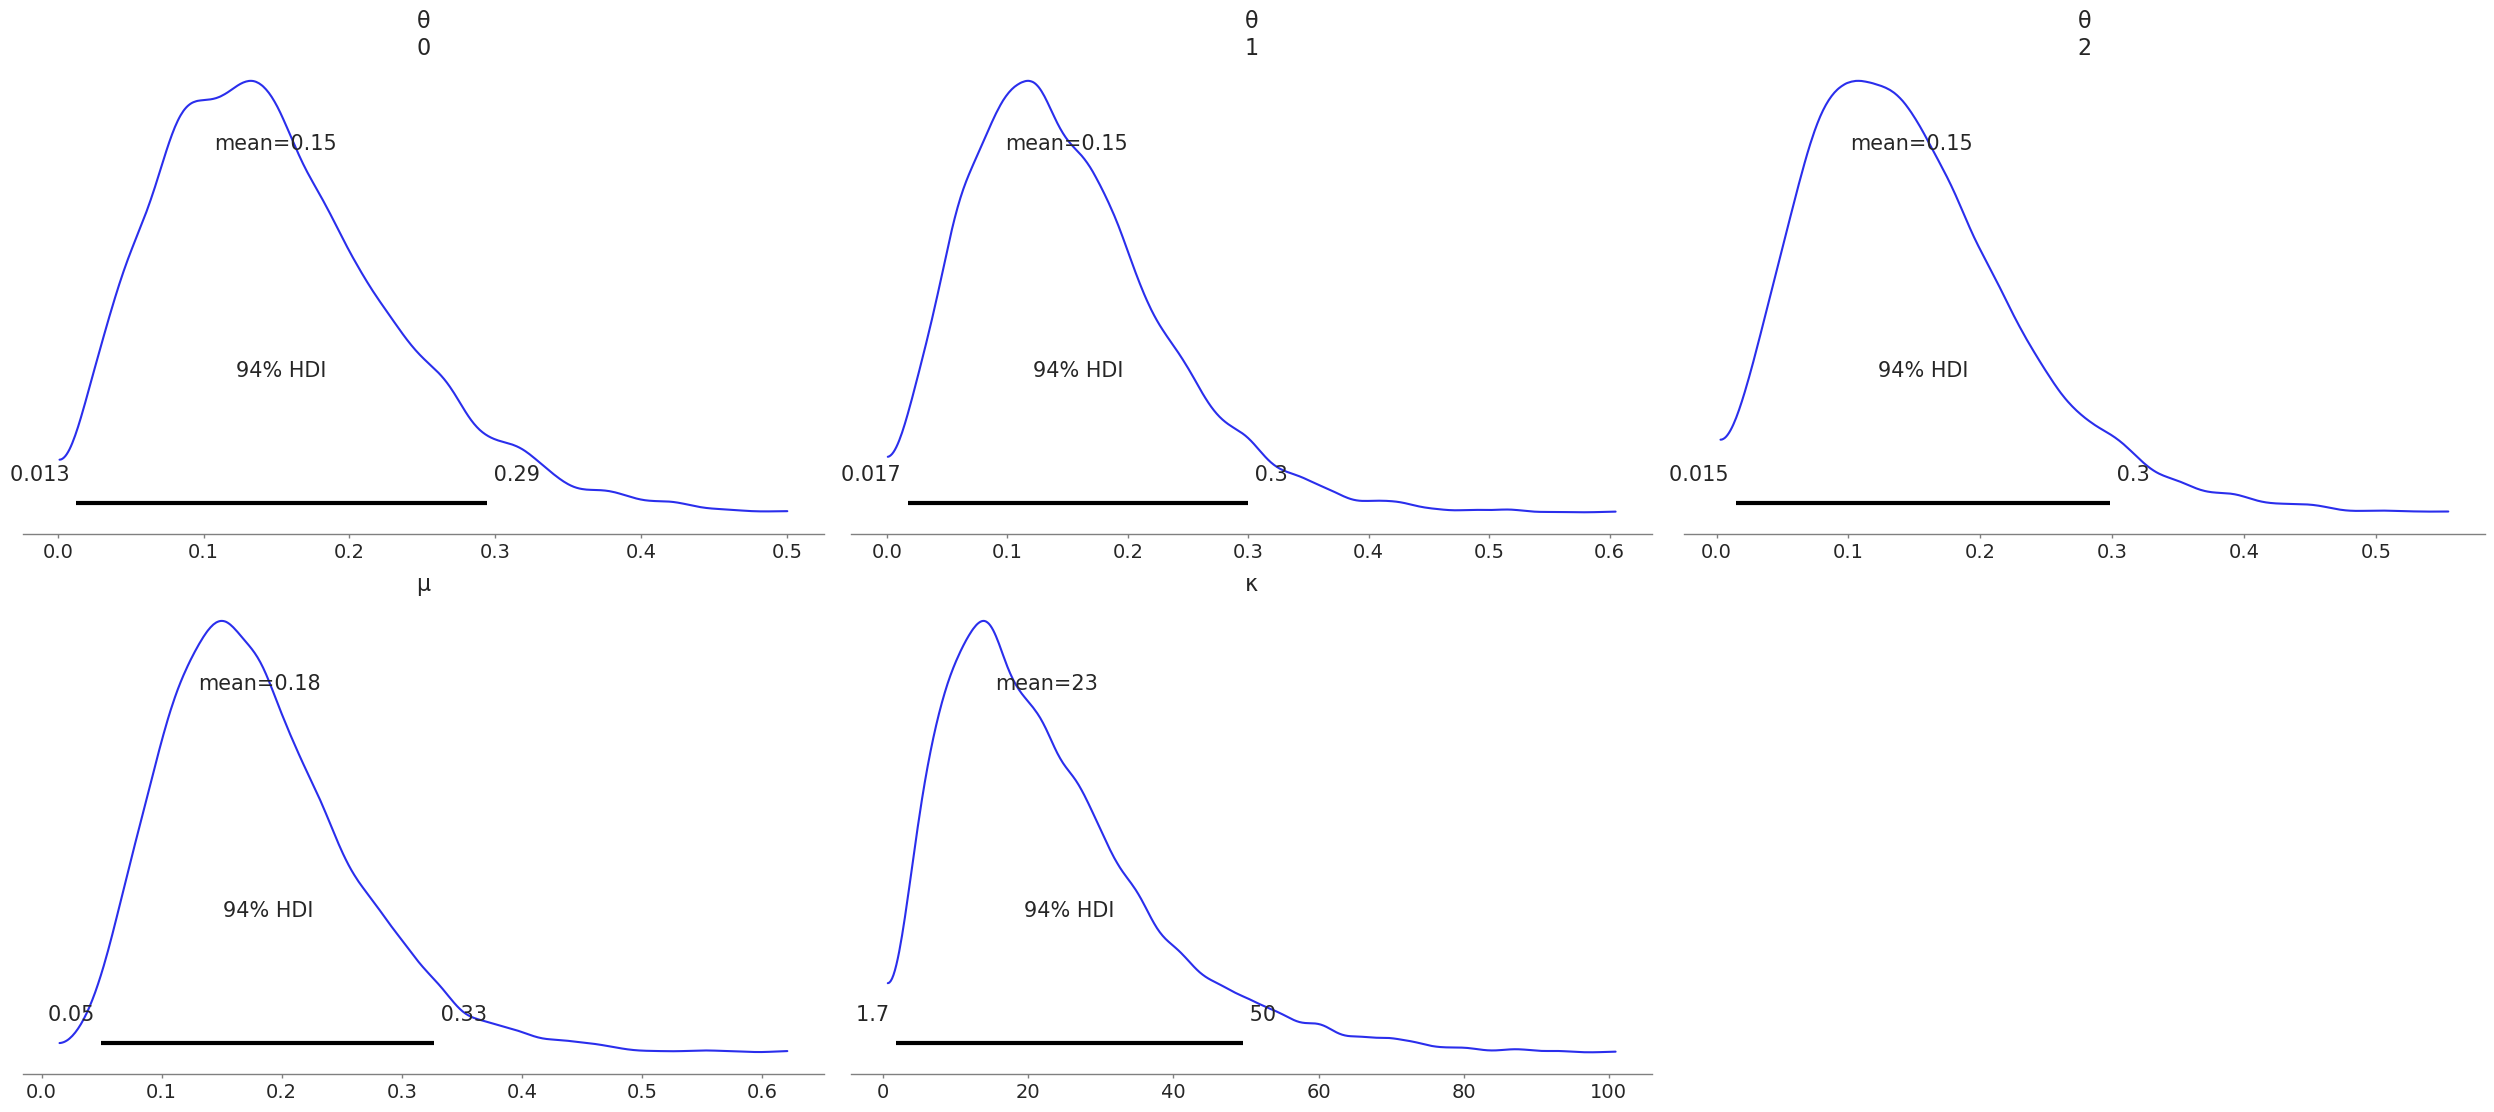

In [7]:
az.plot_posterior(idata_j, var_names=["θ", "μ", "κ"]);

Que valores obtendremos para $\theta_i$ en las siguientes situaciones?


```python
z = [1,1,1] 
z = [9,9,9] 
z = [1,9,9]
```

### Contracción (*shrinking*)

* Los valores de $\theta_i$ provienen de una misma distribución.

* Por lo tanto cada valor de $\theta_i$ (o cada moneda) afecta a las demás y es a su vez afectada por el resto

* Como consecuencia las estimaciones individuales se "contraen" hacia la estimación común.

* El efecto exacto dependerá de la cantidad de observaciones de cada grupo y de cuan similares son los grupos entre si.

* El efecto de Contracción es una forma de regularización, ya que los grupos "comparten información"

### Aminoácidos y proteínas

* Las [proteínas](https://www.youtube.com/watch?v=wvTv8TqWC48) son biomoléculas formadas por 20 unidades, llamadas amino ácidos.
* Cada amino ácido puede aparecer en una proteína 0 o más veces.
* Para un gran número de proteinas hemos medido una propiedad experimentalmente
* La misma propiedad ha sido calculada teóricamente 
* Necesitamos ajustar diferencia teórico-experimental para cada aminoácido a una distribución Gaussiana

In [9]:
cs_data = pd.read_csv('../datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories}

In [10]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=1, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=1, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 
     
    idata_cs_nh = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [11]:
with pm.Model(coords=coords) as cs_h:
    # hyper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=1)
    μ_sd = pm.HalfNormal('μ_sd', 1)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=1, dims="aa") 

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 

    idata_cs_h = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_mu, μ_sd, μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Vamos a comparar los resultados usando un `plot_forest`. ArviZ permite pasar más de un modelo. Esto es útil cuando queremos comparar los valores de parámetros equivalentes entre modelos como en el presente ejemplo. Noten que estamos pasando varios argumentos para obtener el gráfico, como por ejemplo `combined=True` que combina los resultados de todas las cadenas. Los invito a explorar el significado del resto de los parámetros.

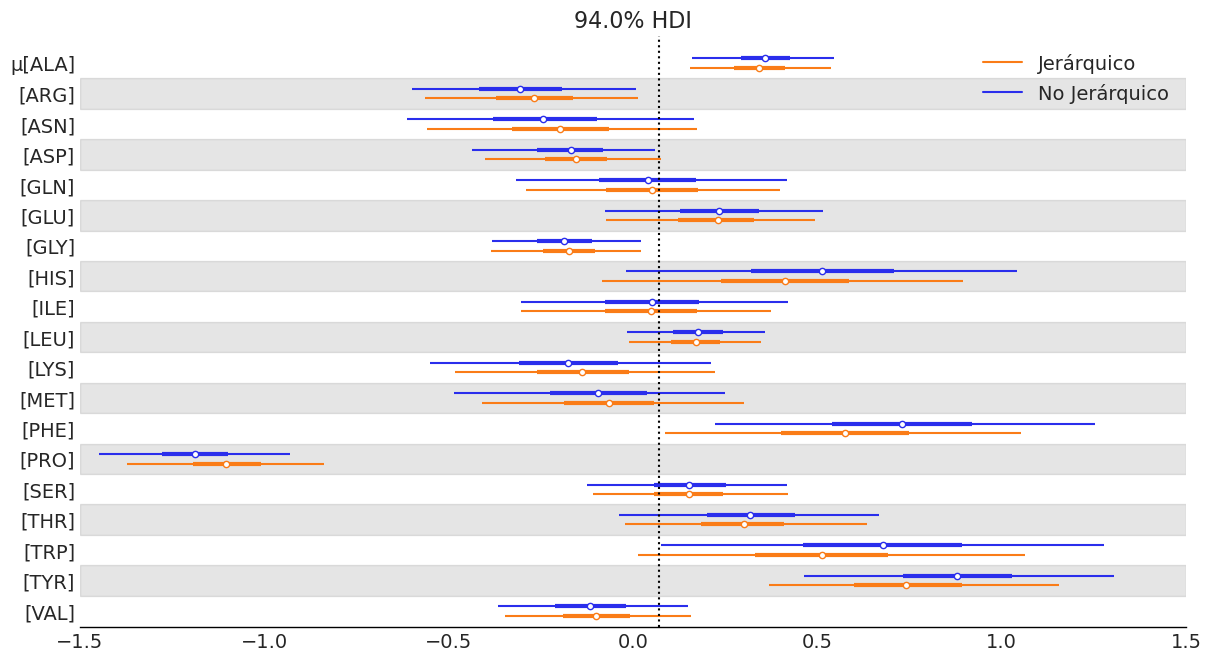

In [20]:
axes = az.plot_forest([idata_cs_nh, idata_cs_h], model_names=['No Jerárquico', 'Jerárquico'],
                      var_names='μ', combined=True, r_hat=False, ess=False, figsize=(12, 6.5),
                      colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":")
axes[0].set_xlim(-1.5, 1.5);